# Applications of Machine Learning - Coursework Submission - Notebook for Model 4
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

28th March 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Applications of Machine Learning* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Applications of Machine Learning - Coursework Assignment](../coursework.pdf). The associated report can be found here: [Applications of Machine Learning - Coursework Report](../report/m2_sd2022_report.pdf).

## Set-Up

### Installations & Imports and Settings

In [2]:
!mkdir -p contents
!pip install pandas
!pip install numpy
!pip install typing
!pip install torch
!pip install accelerate
!pip install torchvision
!pip install tqdm
!pip install ipykernel
!pip install ipython
!pip install scipy
!pip install torchmetrics
!pip install matplotlib
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import matplotlib.image as mpimg
import matplotlib.patches as patches
from scipy.stats import entropy
plt.style.use('sd2022.mplstyle')
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_yellow = '#fada5e'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_neongreen = '#0FFF50'
sd2022_neonblue = '#4D4DFF'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
sd2022_bronze =  '#b08d57'

/Users/steven/anaconda3/envs/m2_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Model

### Create Noise Schedule

In [3]:
# Impulse Noise Degradation
def add_salt_and_pepper(image: torch.Tensor, noise_density) -> torch.Tensor:
    """Adds salt and pepper noise to an image tensor.
    
    Parameters
    ----------
    image : torch.Tensor
        The input image tensor.
    noise_density : float
        The noise density, which represents the amount of salt and pepper noise to add.
        The noise density should be a float between 0 and 0.5.

    Returns
    -------
    torch.Tensor
        The image tensor with salt and pepper noise.
    """
    # Check if the noise_density is a tensor
    if not isinstance(noise_density, float):
        noise_density = noise_density.view(-1, 1, 1, 1)
    # Generate the random tensor H with the same shape as x
    random_image = torch.rand_like(image)
    # Create the salt and pepper masks
    salt_mask = (random_image <= noise_density)
    pepper_mask = (random_image > 1 - noise_density)
    # Apply the masks to the image
    impulse_image = image.clone()  
    impulse_image[salt_mask] = 0.5  
    impulse_image[pepper_mask] = -0.5
    return impulse_image

# Cosine Scheduler
def cosine_scheduler(num_steps: int, initial_noise_level: float, final_noise_level: float, s = 0.0) -> torch.Tensor:
    """Generates a cosine scheduler for the noise level in the impulse noise degradation process.

    Parameters
    ----------
    num_steps : int
        The number of steps in the cosine scheduler.
    initial_noise_level : float
        The initial noise level in the cosine scheduler.
    final_noise_level : float
        The final noise level in the cosine scheduler.
    s : float, optional
        The scaling factor in the cosine scheduler formula, by default 0.0.

    Returns
    -------
    torch.Tensor
        A tensor representing the noise levels at each step in the process.

    References
    ----------
    [1] Alexander Quinn Nichol Quinn Nichol and Prafulla Dhariwal, 
    Improved denoising diffusion probabilistic models, 
    International Conference on Machine Learning, 2021.
    """
    # Check if the noise levels are within the valid range
    assert 0 < initial_noise_level <= final_noise_level and 0 <= final_noise_level < 0.5, "Noise levels must be between 0 and 0.5"
    # Check if the number of steps is valid
    assert num_steps > 0, "num_steps must be a positive integer"
    # Create a tensor representing each step in the process
    steps = torch.arange(num_steps).float()
    # Apply the custom cosine formula
    cos_values = torch.cos((steps / num_steps + s) * torch.pi / (1 + s) / 2) ** 2
    # Normalise the cos_values to range from final_noise_level to initial_noise_level
    noise_levels = cos_values * (initial_noise_level - final_noise_level) + final_noise_level

    return noise_levels


### Define CNN

In [4]:
#CNN Block with Dropout
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
        dropout_prob=0.15 # Add a dropout probability
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm((out_channels, *expected_shape)),
            act(),
            nn.Dropout2d(dropout_prob)  # Add the spatial dropout layer
        )

    def forward(self, x):
        return self.net(x)

# CNN Model 
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

### Diffusion Model

In [5]:
class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt
        noise_schedule = cosine_scheduler(n_T, betas[0], betas[1]) # Generate the noise schedule
        self.register_buffer("noise_levels", noise_schedule)
        self.noise_levels
        self.n_T = n_T
        self.criterion = criterion
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Sample a random time step t
        t = torch.randint(0, self.n_T, (x.shape[0],), device=x.device)
        # Get the noise density for the corresponding time step t
        noise_t = self.noise_levels[t]
        # Apply the impulse noise to the input image x
        z_t = add_salt_and_pepper(x, noise_t)
        # Let the CNN model predict the clean image at time step t
        preds = self.gt(z_t, t / self.n_T)
        return self.criterion(x, preds)
    
    def forward_show(self, t, x: torch.Tensor) -> torch.Tensor:
        # Get the noise density for the corresponding time step t
        noise_t = self.noise_levels[t]
        # Apply the impulse noise to the input image x
        z_t = add_salt_and_pepper(x, noise_t)
        return z_t
    
    def sample(self, mnist_batch: torch.Tensor, n_sample: int, size, device) -> torch.Tensor:
        # Degrade input images with the highest noise level
        _one = torch.ones(n_sample, device=device)
        x = mnist_batch[:n_sample].float().to(device)
        z_t = add_salt_and_pepper(x, self.noise_levels[-1]).float().to(device)
        # Ho et al. (2020), Denoising Diffusion Probabilistic Models, Algorithm 1 
        for t in reversed(range(0, self.n_T)):
            x_0_pred = self.gt(z_t, (t / self.n_T) * _one)
            if t > 0:
                noise_t_minus_1 = self.noise_levels[t - 1]
                z_t = add_salt_and_pepper(x_0_pred, noise_t_minus_1)
            else:
                z_t = x_0_pred
        return z_t

### Hyperparameters

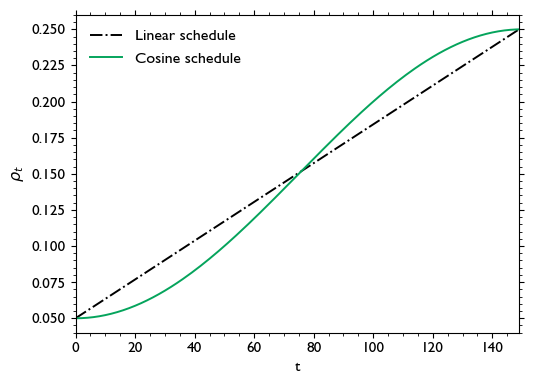

In [6]:
# CNN hyperparameters
n_hidden = (32, 64, 128, 64, 32) 
activation = nn.GELU

# DDPM hyperparameters
betas = (0.05, 0.25) 
n_T =  150

# Training hyperparameters
learning_rate = 2e-4

# Model and optimizer
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=n_hidden, act=activation)
ddpm = DDPM(gt=gt, betas=betas, n_T=n_T)
optim = torch.optim.Adam(ddpm.parameters(), lr=learning_rate)

# Plot cosine schedule and compare to linear schedule
plt.plot(np.linspace(betas[0], betas[1], n_T), label='Linear schedule', linestyle = '-.', color='k')
plt.plot(ddpm.noise_levels.cpu().numpy(), label='Cosine schedule', color=sd2022_green)
plt.xlabel('t')
plt.ylabel(r'$\rho_t$')
plt.legend()
plt.show()

## MNIST Data

### Training and Validation Data Loader

In [7]:
# Data loaders
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("../data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

# Define the sizes for training and validation sets
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Perform the split
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True, generator=torch.Generator().manual_seed(42))

# Create DataLoader for the validation dataset
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=4, generator=torch.Generator().manual_seed(42))


## Training and Sampling

### Device Placement

In [8]:
# Define model and optimizer
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=n_hidden, act=activation)
ddpm = DDPM(gt=gt, betas=betas, n_T=n_T)
optim = torch.optim.Adam(ddpm.parameters(), lr=learning_rate)

# Define accelerator
accelerator = Accelerator()

# Wrap the model, optimizer, and data loaders
ddpm, optim, train_dataloader, validation_dataloader = accelerator.prepare(
    ddpm, optim, train_dataloader, validation_dataloader)

### Test

t=0 -> rho_t=0.04999999701976776
t=25 -> rho_t=0.06339746713638306
t=50 -> rho_t=0.09999999403953552
t=75 -> rho_t=0.15000000596046448
t=100 -> rho_t=0.20000000298023224
t=125 -> rho_t=0.2366025447845459
t=149 -> rho_t=0.24997806549072266


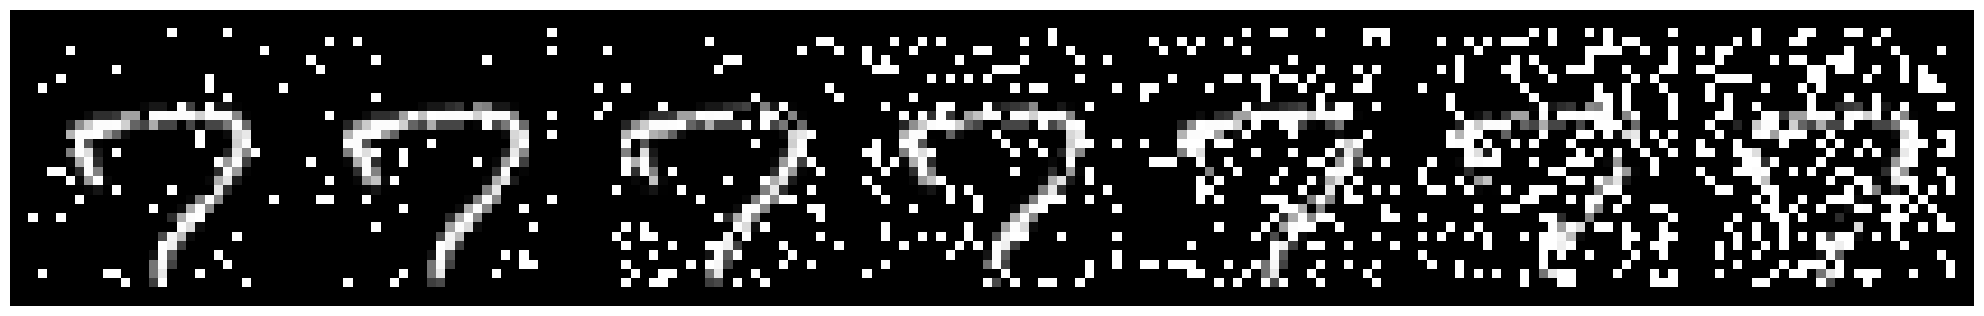

In [9]:
# Test
for x, _ in train_dataloader:
    break

# Plot degradation process for an example image
with torch.no_grad():
    x_first = x[0].unsqueeze(0)
    t_list = [0,25,50,75,100,125,149]
    noisy_images = []
    for t in t_list:
        noisy_image = ddpm.forward_show(t, x_first)
        noisy_images.append(noisy_image)
        print(f"t={t} -> rho_t={ddpm.noise_levels[t]}")
    noisy_images_tensor = torch.cat(noisy_images, dim=0)
    noisy_images_tensor = noisy_images_tensor.to(x.device)
    noisy_images_grid = make_grid(noisy_images_tensor, nrow=len(t_list), padding=2, normalize=True)
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(noisy_images_grid.permute(1, 2, 0).cpu())
    plt.show()

## Training Loop

In [10]:
# Define number of epochs and initialis losses
n_epoch = 75
training_losses = []
validation_losses = []
learning_rates = []

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', factor=0.5, patience=3, verbose=True)

# Directory to save checkpoints and losses
act_string = str(activation).split('.')[-1].split('\'')[0]
base_directory_path = f"../contents/SALTPEPPER_cnn-nh{n_hidden}-act{act_string}_ddpm-b{betas}-nt{n_T}_lr{learning_rate}"
directory_path = base_directory_path
counter = 1
while os.path.exists(directory_path):
    directory_path = f"{base_directory_path}({counter})"
    counter += 1
os.makedirs(directory_path, exist_ok=True)

# Training and Validation
try:
    # Training Loop
    for epoch in range(n_epoch):
        ddpm.train()
        batch_losses = []  
        print(f"Epoch {epoch+1}/{n_epoch}")
        pbar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epoch} - Training")
        for x, _ in pbar_train:
            x = x.to(accelerator.device)
            optim.zero_grad()

            loss = ddpm(x)
            accelerator.backward(loss)

            batch_losses.append(loss.item())
            optim.step()

            avg_loss = np.average(batch_losses)
            pbar_train.set_description(f"Training loss: {avg_loss:.3g}")

        training_losses.append(np.mean(batch_losses))  # Store the average loss for the epoch

        # Validation Loop
        ddpm.eval()
        batch_val_losses = []
        pbar_val = tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{n_epoch} - Validation")
        with torch.no_grad():
            for x_val, _ in pbar_val:
                x_val = x_val.to(accelerator.device)
                val_loss = ddpm(x_val)
                batch_val_losses.append(val_loss.item())
                avg_val_loss = np.average(batch_val_losses)
                pbar_val.set_description(f"Validation loss: {avg_val_loss:.3g}")

        validation_losses.append(np.mean(batch_val_losses))  # Store the average validation loss for the epoch

        # Learning rate scheduler step
        scheduler.step(np.mean(batch_val_losses))
        current_lr = optim.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Save model weights after each epoch
        checkpoint_path = os.path.join(directory_path, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save(ddpm.state_dict(), checkpoint_path)

        # Generate and save sample images after every epoch
        mnist_batch_of_16 = next(iter(train_dataloader))[0][:16].to(accelerator.device)
        with torch.no_grad():
            xh = ddpm.sample(mnist_batch_of_16, 16, (1, 28, 28), accelerator.device)
            grid = make_grid(xh, nrow=4)
            save_image(grid, f"{directory_path}/sample_{epoch:04d}.png")

except KeyboardInterrupt:
    print("Training interrupted. Saving progress...")
    print(base_directory_path)
    pass
finally:
    # Save losses and final model
    np.save(f"{directory_path}/training_losses.npy", np.array(training_losses))
    np.save(f"{directory_path}/validation_losses.npy", np.array(validation_losses))
    np.save(f"{directory_path}/learning_rates.npy", np.array(learning_rates))
    final_model_path = os.path.join(directory_path, "final_model.pth")
    torch.save(ddpm.state_dict(), final_model_path)
    print("Checkpoint and losses saved.")

Epoch 1/75


Validation loss: 0.0148: 100%|██████████| 94/94 [00:19<00:00,  4.90it/s]


Epoch 2/75


Validation loss: 0.0127: 100%|██████████| 94/94 [00:17<00:00,  5.36it/s]


Epoch 3/75


Validation loss: 0.0113: 100%|██████████| 94/94 [00:17<00:00,  5.31it/s]


Epoch 4/75


Validation loss: 0.0102: 100%|██████████| 94/94 [00:21<00:00,  4.28it/s]


Epoch 5/75


Validation loss: 0.00895: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 6/75


Validation loss: 0.00806: 100%|██████████| 94/94 [00:21<00:00,  4.34it/s]


Epoch 7/75


Validation loss: 0.00684: 100%|██████████| 94/94 [00:21<00:00,  4.28it/s]


Epoch 8/75


Validation loss: 0.00603: 100%|██████████| 94/94 [00:22<00:00,  4.10it/s]


Epoch 9/75


Validation loss: 0.00537: 100%|██████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 10/75


Validation loss: 0.00487: 100%|██████████| 94/94 [00:21<00:00,  4.39it/s]


Epoch 11/75


Validation loss: 0.00468: 100%|██████████| 94/94 [00:21<00:00,  4.31it/s]


Epoch 12/75


Validation loss: 0.00409: 100%|██████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 13/75


Validation loss: 0.00387: 100%|██████████| 94/94 [00:22<00:00,  4.10it/s]


Epoch 14/75


Validation loss: 0.00359: 100%|██████████| 94/94 [00:21<00:00,  4.33it/s]


Epoch 15/75


Validation loss: 0.00357: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 16/75


Validation loss: 0.00347: 100%|██████████| 94/94 [00:21<00:00,  4.39it/s]


Epoch 17/75


Validation loss: 0.00329: 100%|██████████| 94/94 [00:21<00:00,  4.44it/s]


Epoch 18/75


Validation loss: 0.00315: 100%|██████████| 94/94 [00:21<00:00,  4.40it/s]


Epoch 19/75


Validation loss: 0.00311: 100%|██████████| 94/94 [00:21<00:00,  4.38it/s]


Epoch 20/75


Validation loss: 0.00295: 100%|██████████| 94/94 [00:21<00:00,  4.34it/s]


Epoch 21/75


Validation loss: 0.00311: 100%|██████████| 94/94 [00:21<00:00,  4.32it/s]


Epoch 22/75


Validation loss: 0.00289: 100%|██████████| 94/94 [00:21<00:00,  4.29it/s]


Epoch 23/75


Validation loss: 0.00277: 100%|██████████| 94/94 [00:21<00:00,  4.35it/s]


Epoch 24/75


Validation loss: 0.00277: 100%|██████████| 94/94 [00:21<00:00,  4.27it/s]


Epoch 25/75


Validation loss: 0.00274: 100%|██████████| 94/94 [00:21<00:00,  4.28it/s]


Epoch 26/75


Validation loss: 0.00268: 100%|██████████| 94/94 [00:21<00:00,  4.33it/s]


Epoch 27/75


Validation loss: 0.00274: 100%|██████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 28/75


Validation loss: 0.00254: 100%|██████████| 94/94 [00:21<00:00,  4.41it/s]


Epoch 29/75


Validation loss: 0.00257: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 30/75


Validation loss: 0.00257: 100%|██████████| 94/94 [00:21<00:00,  4.35it/s]


Epoch 31/75


Validation loss: 0.00251: 100%|██████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 32/75


Validation loss: 0.00244: 100%|██████████| 94/94 [00:17<00:00,  5.45it/s]


Epoch 33/75


Validation loss: 0.00243: 100%|██████████| 94/94 [00:17<00:00,  5.46it/s]


Epoch 34/75


Validation loss: 0.00251: 100%|██████████| 94/94 [00:18<00:00,  5.20it/s]


Epoch 35/75


Validation loss: 0.00256: 100%|██████████| 94/94 [00:17<00:00,  5.34it/s]


Epoch 36/75


Validation loss: 0.00243: 100%|██████████| 94/94 [00:18<00:00,  5.13it/s]


Epoch 37/75


Validation loss: 0.00241: 100%|██████████| 94/94 [00:17<00:00,  5.33it/s]


Epoch 38/75


Validation loss: 0.00235: 100%|██████████| 94/94 [00:17<00:00,  5.26it/s]


Epoch 39/75


Validation loss: 0.0024: 100%|██████████| 94/94 [00:18<00:00,  5.19it/s] 


Epoch 40/75


Validation loss: 0.00235: 100%|██████████| 94/94 [00:17<00:00,  5.42it/s]


Epoch 41/75


Validation loss: 0.00232: 100%|██████████| 94/94 [00:18<00:00,  5.21it/s]


Epoch 42/75


Validation loss: 0.00237: 100%|██████████| 94/94 [00:17<00:00,  5.25it/s]


Epoch 43/75


Validation loss: 0.00227: 100%|██████████| 94/94 [00:18<00:00,  5.10it/s]


Epoch 44/75


Validation loss: 0.00228: 100%|██████████| 94/94 [00:18<00:00,  5.19it/s]


Epoch 45/75


Validation loss: 0.00228: 100%|██████████| 94/94 [00:18<00:00,  5.17it/s]


Epoch 46/75


Validation loss: 0.00225: 100%|██████████| 94/94 [00:18<00:00,  5.18it/s]


Epoch 47/75


Validation loss: 0.00222: 100%|██████████| 94/94 [00:17<00:00,  5.36it/s]


Epoch 48/75


Validation loss: 0.00224: 100%|██████████| 94/94 [00:17<00:00,  5.23it/s]


Epoch 49/75


Validation loss: 0.00215: 100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


Epoch 50/75


Validation loss: 0.00218: 100%|██████████| 94/94 [00:17<00:00,  5.24it/s]


Epoch 51/75


Validation loss: 0.00215: 100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


Epoch 52/75


Validation loss: 0.00225: 100%|██████████| 94/94 [00:18<00:00,  5.18it/s]


Epoch 53/75


Validation loss: 0.00222: 100%|██████████| 94/94 [00:17<00:00,  5.34it/s]


Epoch 54/75


Validation loss: 0.00212: 100%|██████████| 94/94 [00:22<00:00,  4.14it/s]


Epoch 55/75


Validation loss: 0.00215: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 56/75


Validation loss: 0.00202: 100%|██████████| 94/94 [00:21<00:00,  4.29it/s]


Epoch 57/75


Validation loss: 0.00207: 100%|██████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 58/75


Validation loss: 0.0021: 100%|██████████| 94/94 [00:21<00:00,  4.47it/s] 


Epoch 59/75


Validation loss: 0.002: 100%|██████████| 94/94 [00:21<00:00,  4.42it/s]  


Epoch 60/75


Validation loss: 0.0021: 100%|██████████| 94/94 [00:21<00:00,  4.38it/s] 


Epoch 61/75


Validation loss: 0.00204: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 62/75


Validation loss: 0.00206: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 63/75


Validation loss: 0.00199: 100%|██████████| 94/94 [00:21<00:00,  4.29it/s]


Epoch 64/75


Validation loss: 0.00199: 100%|██████████| 94/94 [00:21<00:00,  4.36it/s]


Epoch 65/75


Validation loss: 0.002: 100%|██████████| 94/94 [00:17<00:00,  5.27it/s]  


Epoch 66/75


Validation loss: 0.00198: 100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


Epoch 67/75


Validation loss: 0.00199: 100%|██████████| 94/94 [00:17<00:00,  5.39it/s]


Epoch 68/75


Validation loss: 0.00198: 100%|██████████| 94/94 [00:17<00:00,  5.23it/s]


Epoch 69/75


Validation loss: 0.00202: 100%|██████████| 94/94 [00:17<00:00,  5.30it/s]


Epoch 70/75


Validation loss: 0.00199: 100%|██████████| 94/94 [00:17<00:00,  5.24it/s]


Epoch 71/75


Validation loss: 0.00201: 100%|██████████| 94/94 [00:17<00:00,  5.40it/s]


Epoch 72/75


Validation loss: 0.00199: 100%|██████████| 94/94 [00:17<00:00,  5.25it/s]


Epoch 73/75


Validation loss: 0.00192: 100%|██████████| 94/94 [00:17<00:00,  5.22it/s]


Epoch 74/75


Validation loss: 0.0019: 100%|██████████| 94/94 [00:17<00:00,  5.36it/s] 


Epoch 75/75


Validation loss: 0.00194: 100%|██████████| 94/94 [00:17<00:00,  5.36it/s]


Checkpoint and losses saved.


## Performance Metrics

### Training and Validation Loss Curves

In [11]:
# Directoy of the contents
directory_path = '../contents'

if os.path.exists(directory_path):
    print("Contents of the directory:")
    for item in os.listdir(directory_path):
        print(item)
else:
    print(f"No such directory: {directory_path}")

Contents of the directory:
RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)
.DS_Store
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt120_lr0.0005
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt80_lr0.0005
RUN_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.0001, 0.05)-nt1200_lr0.001
SALTPEPPERRAW_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002


Average training loss: 0.004614527337148214
Average validation loss: 0.002973921909832458
Final training loss: 0.0024817197987188895
Final validation loss: 0.001486719921578039
Minimum validation loss: 0.0014579637159415064
Epoch of minimum validation loss: 71


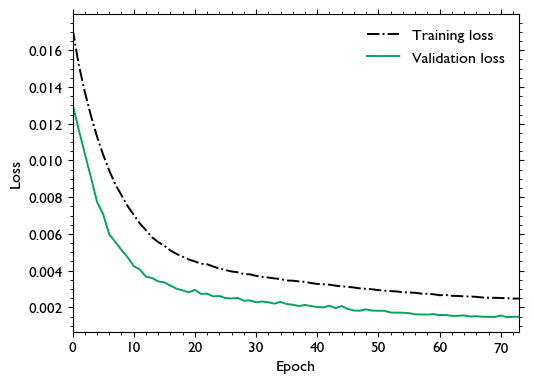

In [12]:
# Select Run to load (copy paste from above)
run_name = "SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)"

# Load the losses
training_losses = np.load(f"../contents/{run_name}/training_losses.npy")[1:]
validation_losses = np.load(f"../contents/{run_name}/validation_losses.npy")[1:]
learning_rates = np.load(f"../contents/{run_name}/learning_rates.npy")[1:]


# Visualize the losses
plt.figure(figsize=(5.5, 4))
plt.plot(training_losses, label="Training loss",  linestyle = '-.', color = 'black')
plt.plot(validation_losses, label="Validation loss", color = sd2022_green)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
print("Average training loss:", np.mean(training_losses))
print("Average validation loss:", np.mean(validation_losses))
print("Final training loss:", training_losses[-1])
print("Final validation loss:", validation_losses[-1])
print("Minimum validation loss:", np.min(validation_losses))
print("Epoch of minimum validation loss:", np.argmin(validation_losses))



### FID Score 

In [13]:
try:
    # Get real images
    real_images_list = []
    images_needed = 100
    for images, _ in train_dataloader:
        real_images_list.append(images.to(accelerator.device))
        if sum(len(images) for images in real_images_list) >= images_needed:
            break  
    real_images = torch.cat(real_images_list, dim=0)[:images_needed]

    # Load the model 
    run_name = "SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)"
    epochs = [10, 48, 75]

    def get_fake_images(epoch, run_name):
        """Get generated images from the model at a specific epoch.
        """
        ddpm = DDPM(gt=gt, betas=(0.05, 0.25), n_T=150)
        checkpoint_path = f'../contents/{run_name}/checkpoint_epoch_{epoch}.pth'
        model = torch.load(checkpoint_path)

        accumulated_images = []
        accumulated_count = 0
        for batch in train_dataloader:
            images = batch[0].to(accelerator.device)  # Assuming the first element of the batch is the images
            accumulated_images.append(images)
            accumulated_count += images.size(0)
            if accumulated_count >= 100:
                break
        mnist_batch_of_1000 = torch.cat(accumulated_images, dim=0)[:100]

        # Get fake images
        with torch.no_grad():
            ddpm.load_state_dict(model)
            ddpm.to('cpu')
            fake_images = ddpm.sample(mnist_batch_of_1000, images_needed, (1, 28, 28), device='cpu')
        return fake_images

    # Calculate the FID score
    def calculate_fid_score(real_images, fake_images):
        """Calculate the FID score between real and generated images.
        """
        # Prepare the images
        real_images_rgb, fake_images_rgb = real_images.repeat(1, 3, 1, 1), fake_images.repeat(1, 3, 1, 1)
        real_images_rgb, fake_images_rgb = real_images_rgb.to('cpu'), fake_images_rgb.to('cpu')
        real_images_rgb, fake_images_rgb = (real_images_rgb + 0.5) / (torch.max(real_images_rgb) - torch.min(real_images_rgb)), (fake_images_rgb - torch.min(fake_images_rgb)) / (torch.max(fake_images_rgb) - torch.min(fake_images_rgb))
        real_images_rgb = real_images_rgb.float() 
        fake_images_rgb = fake_images_rgb.float()
        # Calculate FID score
        with torch.no_grad():
            fid = FrechetInceptionDistance(normalize=True)
            for i in range(10):
                batch_real = real_images_rgb[i*10:(i+1)*10].float()  
                batch_fake = fake_images_rgb[i*10:(i+1)*10].float() 
                if batch_real.size(0) > 0 and batch_fake.size(0) > 0:
                    fid.update(batch_real, real=True)
                    fid.update(batch_fake, real=False)
        print(f"FID: {float(fid.compute())}")
        return float(fid.compute())

    # Save FID scores
    fid_scores = []
    for epoch in epochs:
        fake_images = get_fake_images(epoch, run_name)
        fid_score = calculate_fid_score(real_images, fake_images)
        fid_scores.append(fid_score)

    df_fid = pd.DataFrame(fid_scores, columns=["FID score"], index=epochs)
    df_fid.to_csv(f"../contents/{run_name}/fid_scores.csv")

except KeyboardInterrupt:
    print("Interrupted.")
    pass

FID: 171.6013946533203
FID: 74.55245208740234
FID: 113.83448791503906


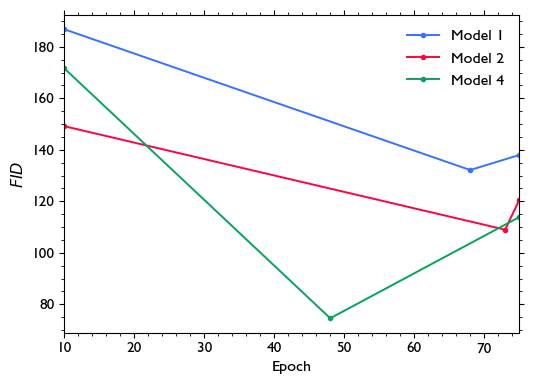

In [14]:
# Load the FID scores
run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"
run_name2 = "RUN_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.0001, 0.05)-nt1200_lr0.001"
run_name3 = "SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)"
df_fid = pd.read_csv(f"../contents/{run_name}/fid_scores.csv", index_col=0)
df_fid2 = pd.read_csv(f"../contents/{run_name2}/fid_scores.csv", index_col=0)
df_fid3 = pd.read_csv(f"../contents/{run_name3}/fid_scores.csv", index_col=0)

# Visualize the FID scores
plt.figure(figsize=(5.5, 4))
plt.plot(df_fid, marker='.', color=sd2022_blue, label = 'Model 1')
plt.plot(df_fid2, marker='.', color=sd2022_red, label = 'Model 2')
plt.plot(df_fid3, marker='.', color=sd2022_green, label = 'Model 4')
plt.xlabel("Epoch")
plt.ylabel(r'$FID$')
plt.legend()
plt.show()



### IS Score

In [15]:
# Define the CNN classifier
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x  

model = CNNClassifier()
model.to(accelerator.device)

# Load the CNN classifier
cnn_model_name = "../classifier_models/cnn_classifier4.pth"
state_dict = torch.load(cnn_model_name, map_location=accelerator.device)
model.load_state_dict(state_dict)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


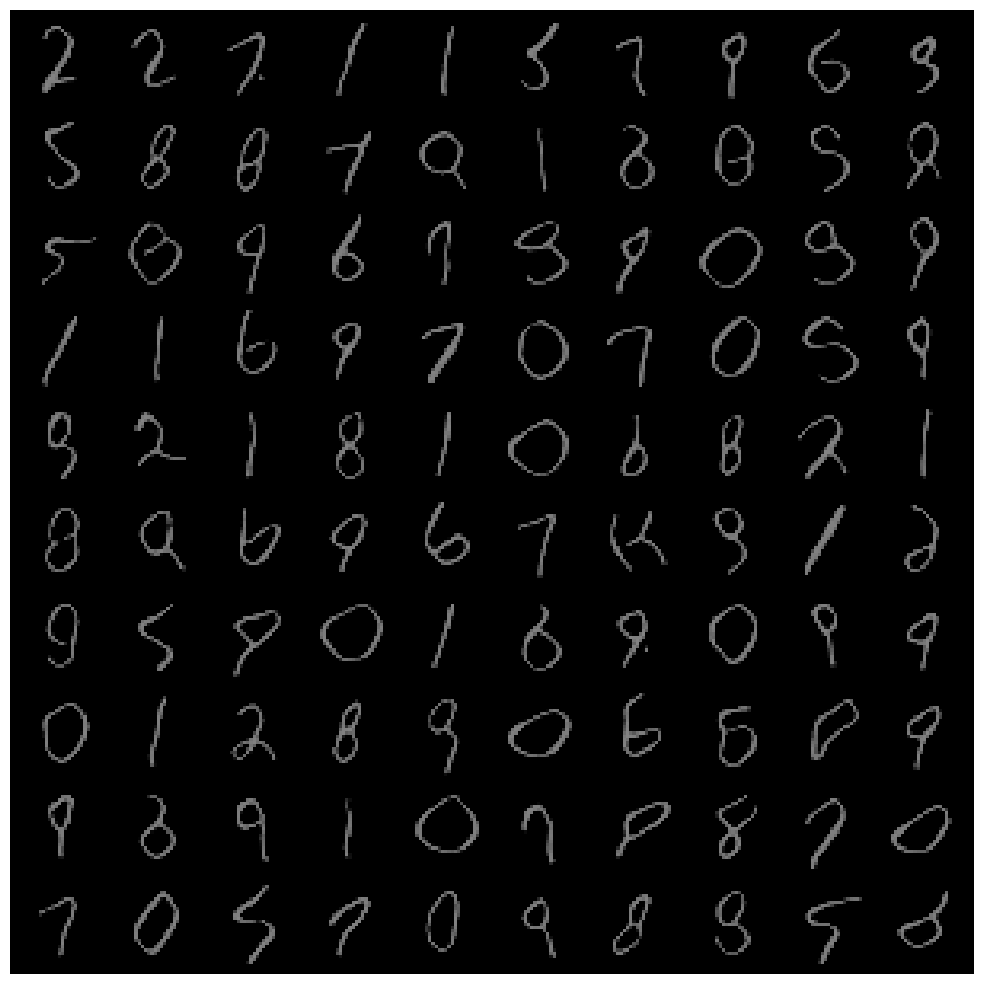

In [16]:
try:
    # Define DDPM
    run_name = "SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)"
    ep = 48

    # Generate samples
    def generate_images(epoch, run_name, n_images):
        """Sample images from the model at a specific epoch."""
        ddpm = DDPM(gt=gt, betas=(0.05, 0.25), n_T=150)
        checkpoint_path = f'../contents/{run_name}/checkpoint_epoch_{epoch}.pth'
        model = torch.load('../ddpm_models/model4.pth')

        accumulated_images = []
        accumulated_count = 0
        for batch in train_dataloader:
            images = batch[0].to(accelerator.device)  # Assuming the first element of the batch is the images
            accumulated_images.append(images)
            accumulated_count += images.size(0)
            if accumulated_count >= 1000:
                break
        mnist_batch_of_1000 = torch.cat(accumulated_images, dim=0)[:1000]

        # Get fake images
        with torch.no_grad():
            ddpm.load_state_dict(model)
            ddpm.to(accelerator.device)
            images = ddpm.sample(mnist_batch_of_1000, n_images, (1, 28, 28), device=accelerator.device)
        return images

    images = generate_images(ep, run_name, 1000)
    images100 = images[:100]
    images_grid = make_grid(images100, nrow=10, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(images_grid.permute(1, 2, 0).cpu())


    # Predict labels for the images
    def predict_labels(images, model):
        """Predict labels for the images using the CNN classifier."""
        model.eval()
        images = images.to(accelerator.device)
        with torch.no_grad():
            test_output, last_layer = model(images)
            predicted = torch.max(test_output, 1)[1].data.squeeze()
        return predicted, last_layer

    predicted_labels, last_layer = predict_labels(images, model)
    predicted_labels = predicted_labels.cpu()
    last_layer = last_layer.cpu()

    # Save the predicted labels
    df = pd.DataFrame(predicted_labels.numpy(), columns=["Predicted labels"])
    df.to_csv(f"../contents/{run_name}/predicted_labels.csv")

    # Save the last layer predictions
    np.save(f"../contents/{run_name}/last_layer.npy", last_layer.numpy())

    # Clear existing directories and save images in new directories based on predicted labels
    for i in range(10):
        dir_path = f"../contents/{run_name}/predicted_labels/{i}"
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    # Save images in folders depending on prediction
    for i in range(1000):
        save_image(images[i].unsqueeze(0), f"../contents/{run_name}/predicted_labels/{predicted_labels[i]}/{i}.png")

except KeyboardInterrupt:
    print("Interrupted.")
    pass

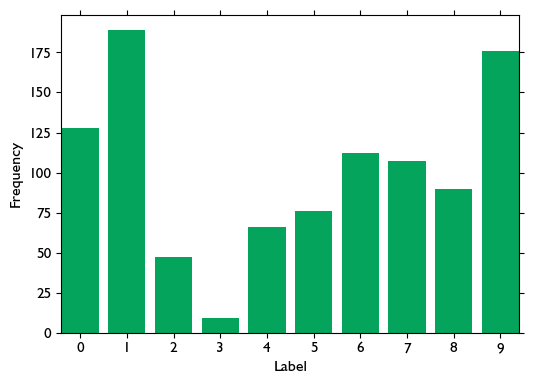

In [17]:
# Load the predicted labels
df = pd.read_csv(f"../contents/{run_name}/predicted_labels.csv")
predicted_labels = df["Predicted labels"].values

# Plot prediction histogram
label_freq = [np.sum(predicted_labels == i) for i in range(10)]
plt.figure(figsize=(5.5, 4))
plt.bar(range(10), label_freq, color=sd2022_green)
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.minorticks_off()
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [18]:
# Inception Score function
def inception_score_from_preds(preds, splits=10):
    """Calculate the Inception Score from precomputed predictions."""
    scores = []
    N = preds.shape[0]
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(entropy(part, py, base=np.e, axis=1)))) 
    return np.mean(scores), np.std(scores)

# Load the inception predictions
inception_preds = np.load(f"../contents/{run_name}/last_layer.npy")
logits = torch.tensor(inception_preds)  # Convert to a PyTorch tensor if not already
probs = torch.nn.functional.softmax(logits, dim=1).numpy()  # Apply softmax and convert back to numpy

# Calculate the Inception Score
inception_score, inception_std = inception_score_from_preds(probs)
print(f"Inception Score: {inception_score:.3f} ± {inception_std:.3f}")

Inception Score: 3.115 ± 0.164


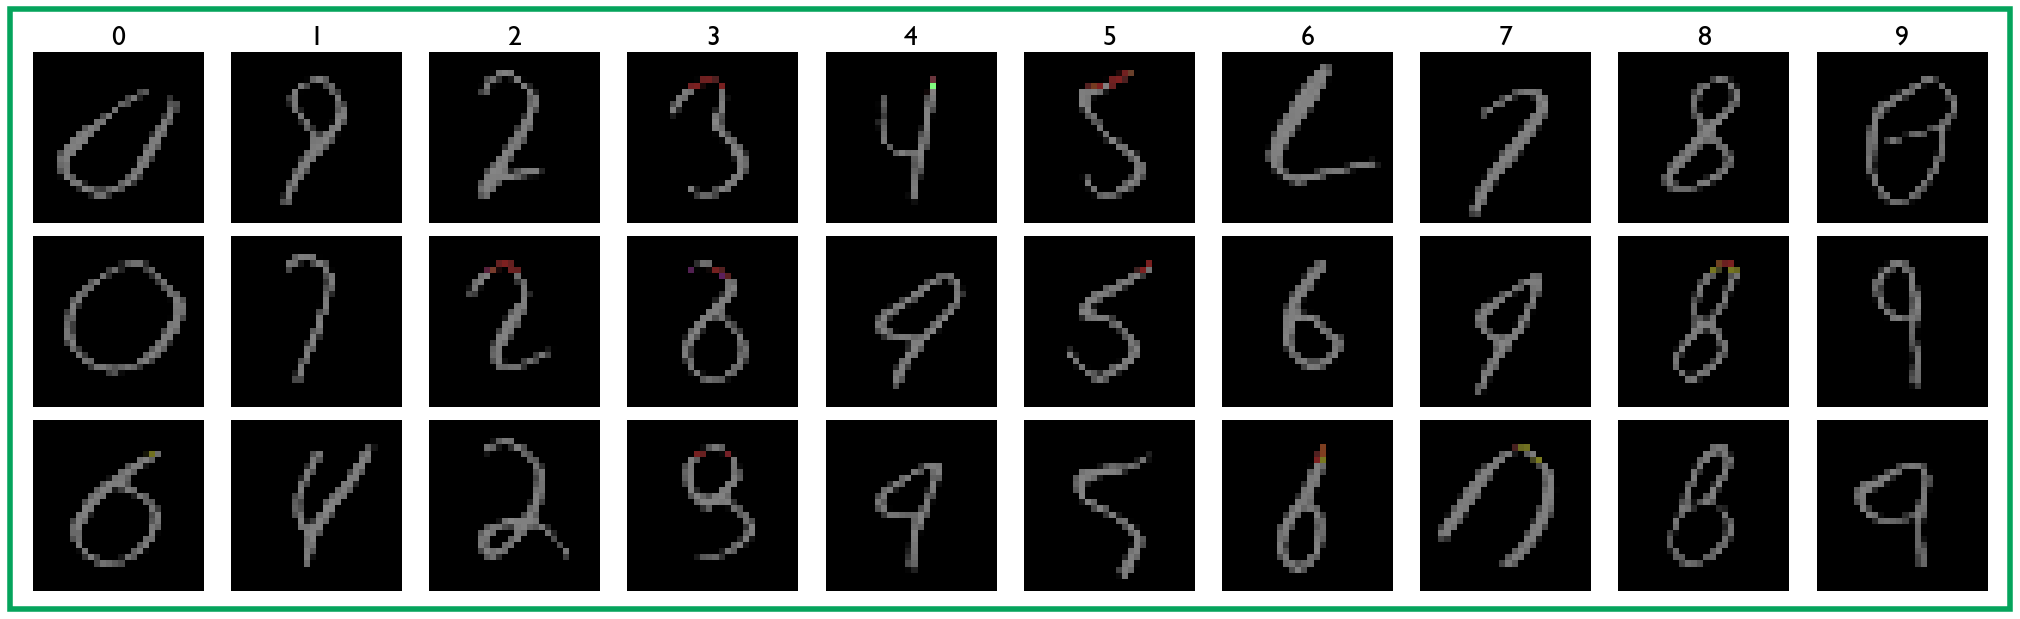

In [19]:
# Display 3 images for each digit

run_name = "SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt150_lr0.0002(1)"
base_path = f"../contents/{run_name}/predicted_labels"

n_digits = 10  
n_images_per_digit = 3  

fig, axes = plt.subplots(n_images_per_digit, n_digits, figsize=(n_digits * 2, n_images_per_digit * 2))

for digit in range(n_digits):
    digit_path = os.path.join(base_path, str(digit))
    image_files = sorted(os.listdir(digit_path))[:n_images_per_digit] 
    
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(digit_path, image_file)
        img = mpimg.imread(img_path)

        if i == 0:
            axes[i,digit].set_title(digit, fontsize = 20)
        
        axes[i, digit].imshow(img) 
        axes[i, digit].axis('off')

plt.tight_layout()
rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor=sd2022_green, facecolor='none', transform=fig.transFigure, clip_on=False)
fig.patches.append(rect)
plt.show()

